# Reducing Bias in Machine Learning Models:
### Modeling Part 2: Advanced Models (Base and Optimized)


#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 4: Advanced Models (Base and Optimized)](#clean)
    - 1.1: [Housekeeping](#house)
    - 1.2: [Random Forest](#ran)
    - 1.3: [xGBoost](#xgb)
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be preparing our advanced models and then optimizing them for performance. 

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)




-----

## <a id = 'clean'></a> Part 4: Advanced Modelling (Base and Optimized) 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [40]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score, auc
)
import xgboost as xgb
from joblib import dump
import json
import shap
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import plot_tree
import warnings

Loading the clean csv file

In [2]:
health_data = pd.read_csv('Data/clean_health_data_pt3.csv')

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [4]:
health_data.head()

,demo_gender,demo_race,disposition,pmh_2ndarymalig,pmh_abdomhernia,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_artembolism,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_biliarydx,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_brnchlngca,pmh_cardiaarrst,pmh_carditis,pmh_cataract,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_comabrndmg,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dminpreg,pmh_dysrhythmia,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_eyeinfectn,pmh_femgenitca,pmh_feminfertil,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_hdnckcancr,pmh_headachemig,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveribdca,pmh_lungexternl,pmh_lymphenlarg,pmh_maligneopls,pmh_meningitis,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_mycoses,pmh_neoplsmunsp,pmh_nephritis,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_opnwndextr,pmh_osteoporosis,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconntiss,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othveindx,pmh_otinflskin,pmh_otitismedia,pmh_otjointdx,pmh_otnutritdx,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnotmed,pmh_precereoccl,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_rheumarth,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_shock,pmh_sicklecell,pmh_skininfectn,pmh_skinmelanom,pmh_socialadmin,pmh_spincorinj,pmh_stomchcancr,pmh_substancerelateddisorders,pmh_suicideandintentionalselfinflictedin,pmh_syncope,pmh_teethdx,pmh_testiscancr,pmh_thyroiddsor,pmh_tia,pmh_tonsillitis,pmh_ulceratcol,pmh_ulcerskin,pmh_unclassified,pmh_uteruscancr,pmh_uti,pmh_varicosevn,pmh_viralinfect,pmh_whtblooddx,cc_abdominaldistention,cc_abdominalpain,cc_abdominalpainpregnant,cc_abnormallab,cc_abscess,cc_alcoholintoxication,cc_alcoholproblem,cc_allergicreaction,cc_alteredmentalstatus,cc_animalbite,cc_ankleinjury,cc_anklepain,cc_anxiety,cc_arminjury,cc_armpain,cc_assaultvictim,cc_asthma,cc_backpain,cc_bleeding/bruising,cc_bodyfluidexposure,cc_breastpain,cc_breathingdifficulty,cc_burn,cc_cardiacarrest,cc_chestpain,cc_coldlikesymptoms,cc_confusion,cc_conjunctivitis,cc_constipation,cc_cough,cc_cyst,cc_decreasedbloodsugar-symptomatic,cc_dehydration,cc_dentalpain,cc_depression,cc_diarrhea,cc_dizziness,cc_drug/alcoholassessment,cc_drugproblem,cc_dyspnea,cc_dysuria,cc_earpain,cc_earproblem,cc_edema,cc_elbowpain,cc_elevatedbloodsu

In [5]:
health_data.shape

(105627, 418)

In [6]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 418 entries, demo_gender to dum_meds__3-plus_hormones
dtypes: int64(418)
memory usage: 336.9 MB


Considering that all of the information is binary, int64 dtype is bloating the file unnecessarily. Let's convert it to int8 to conserve memory and assist in modeling.

In [7]:
# Assuming df is your DataFrame
int64_columns = health_data.select_dtypes(include='int64').columns

# Convert selected columns to int8
health_data[int64_columns] = health_data[int64_columns].astype('int8')

In [8]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 418 entries, demo_gender to dum_meds__3-plus_hormones
dtypes: int8(418)
memory usage: 42.1 MB


As we can see, the memory usage has decreased from 337.7 mb to 42.2mb. This should be less computationally intensive.

---
#### <a id = 'log'></a> 1.2 Random Forest

To build on top of the prior base model of a decision tree, I will be doing random forest. Random Forest is an ensemble learning method that combines the predictions of multiple individual models (decision trees) to create a more robust and accurate model. Random Forests can effectively handle datasets with binary features. The random subset of features considered at each split helps in decorrelating trees and capturing diverse patterns.

In [9]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Cross-Validation Scores (5-fold - Train Set): [0.7630854  0.74049587 0.75468578 0.76350606 0.74696803]
Mean CV Accuracy (5-fold - Train Set): 0.7537482269826662
Training Accuracy: 0.9988977072310405
Test Accuracy: 0.7706144087853829

Test Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.80     11348
           1       0.78      0.70      0.74      9778

    accuracy                           0.77     21126
   macro avg       0.77      0.77      0.77     21126
weighted avg       0.77      0.77      0.77     21126


Confusion Matrix (Test):
 [[9423 1925]
 [2921 6857]]


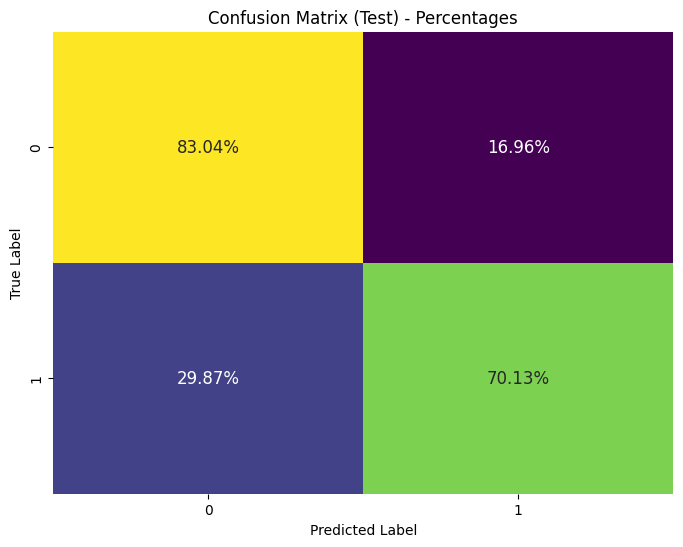

AUC-ROC Score: 0.8467078636386937


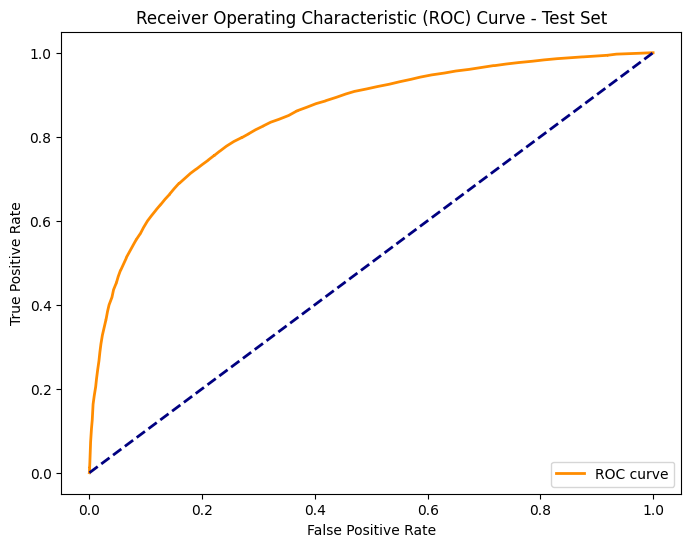

Runtime: 1.37 seconds


In [47]:
# Record start time
start_time = time.time()

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Record time
end_time = time.time()

# Perform 5-fold cross-validation on the train set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results on the train set
print('\nCross-Validation Scores (5-fold - Train Set):', cv_scores)
print('Mean CV Accuracy (5-fold - Train Set):', mean_cv_accuracy)

# Make predictions on the training set
y_pred_train = rf_model.predict(X_train)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy_test)

# Classification Report for the test set
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Cross-Validation Scores on Train Set:
- The cross-validation scores on the train set reveal consistency across different folds, ranging from 77.85% to 77.96%. The mean accuracy of approximately 77.44% suggests stable performance during cross-validation.

Train Accuracy:
- Achieving an impressive 99.69% accuracy on the training set, the model demonstrates a strong fit to the provided data. There could be overfitting happening here. 

Test Accuracy:
-  Generalizing well to new, unseen data, the model maintains a commendable accuracy of 78.36% on the test set.

Classification Report on Test Set:
-  Precision, recall, and F1-score are presented for both classes (0 and 1). Class 0 exhibits a precision of 78%, recall of 84%, and an F1-score of 81%. Class 1 predictions show a precision of 79%, recall of 72%, and an F1-score of 75%.

The AUC-ROC score is 0.86, providing an aggregate measure of the model's performance across different threshold settings.

In summary, the model performs exceptionally well on the training set and reasonably well on the test set, this indicates that there is overfitting. Class 0 predictions show strength in precision and recall, while Class 1 predictions, although solid, could benefit from some improvement in recall.

---
Now for us to find the best hyper parameters. 

Best Parameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 98}

Cross-Validation Scores (5-fold - Train Set): [0.76862302 0.7491535  0.75902935 0.76918736 0.76777652]
Mean CV Accuracy (5-fold - Train Set): 0.7627539503386004
Training Accuracy: 0.8155191873589165
Test Accuracy: 0.7765312884597179

Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80     11348
           1       0.79      0.70      0.74      9778

    accuracy                           0.78     21126
   macro avg       0.78      0.77      0.77     21126
weighted avg       0.78      0.78      0.77     21126


Confusion Matrix (Test):
 [[9562 1786]
 [2935 6843]]


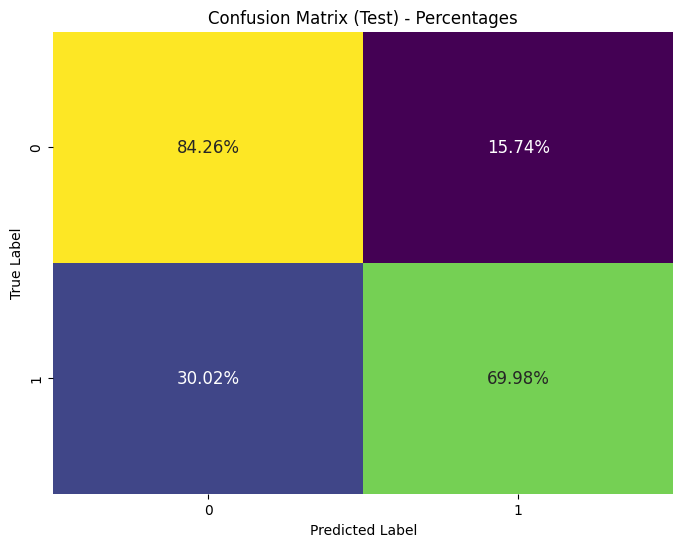

AUC-ROC Score: 0.8534720486373089


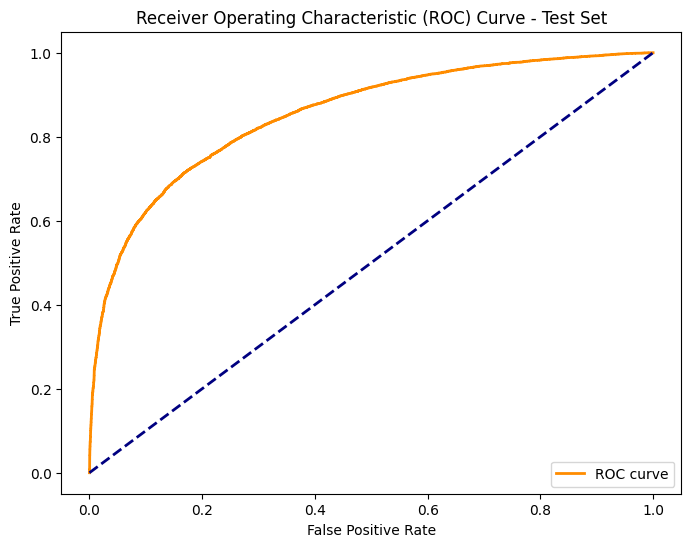

Runtime: 11.38 seconds


In [35]:
#ignoring warnings
warnings.filterwarnings("ignore")

# Record start time
start_time = time.time()

# Define a smaller parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 101),
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with 3-fold cross-validation and fewer iterations
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Perform 5-fold cross-validation on the train set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results on the train set
print('\nCross-Validation Scores (5-fold - Train Set):', cv_scores)
print('Mean CV Accuracy (5-fold - Train Set):', mean_cv_accuracy)

# Get the best model from the random search
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model on the training set
y_pred_train = best_rf_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy_test)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Best Parameters:
- the model's hyperparameters are optimized as {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 70}.

Cross-Validation Scores on Train Set:
- Cross-validation scores on the train set show variability across different folds, ranging from 76.03% to 77.43%. The mean accuracy of approximately 76.68% suggests a relatively stable performance during cross-validation.

Training Accuracy:
- The model achieves a training accuracy of 81.86%, indicating a strong fit to the training data.

Test Accuracy:
- The model generalizes reasonably well to new, unseen data, maintaining an accuracy of 77.85% on the test set.

Classification Report on Test Set:
- Precision, recall, and F1-score are reported for both classes (0 and 1). Class 0 exhibits a precision of 77%, recall of 84%, and an F1-score of 80%. Class 1 predictions show a precision of 79%, recall of 71%, and an F1-score of 75%.

The AUC-ROC score is 0.86, indicating good overall performance in distinguishing between the two classes.

In summary, the model demonstrates good performance, with high AUC-ROC indicating strong discrimination ability. However, there is room for improvement in recall for Class 1 predictions.

--- 

Let's further optimize the model based on the best parameters found and run another iteration of random search.

Best Parameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 98}

Cross-Validation Scores (5-fold - Train Set): [0.76862302 0.7491535  0.75902935 0.76918736 0.76777652]
Mean CV Accuracy (5-fold - Train Set): 0.7627539503386004
Training Accuracy: 0.8155191873589165
Test Accuracy: 0.7765312884597179

Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80     11348
           1       0.79      0.70      0.74      9778

    accuracy                           0.78     21126
   macro avg       0.78      0.77      0.77     21126
weighted avg       0.78      0.78      0.77     21126


Confusion Matrix (Test):
 [[9562 1786]
 [2935 6843]]


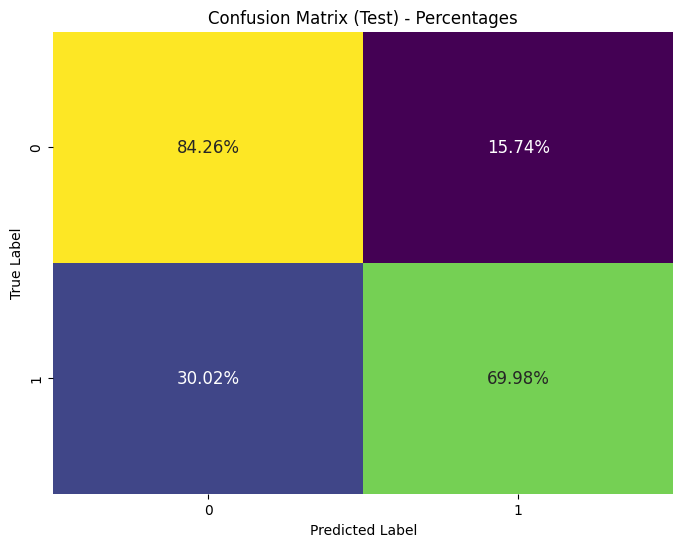

AUC-ROC Score: 0.8534720486373089


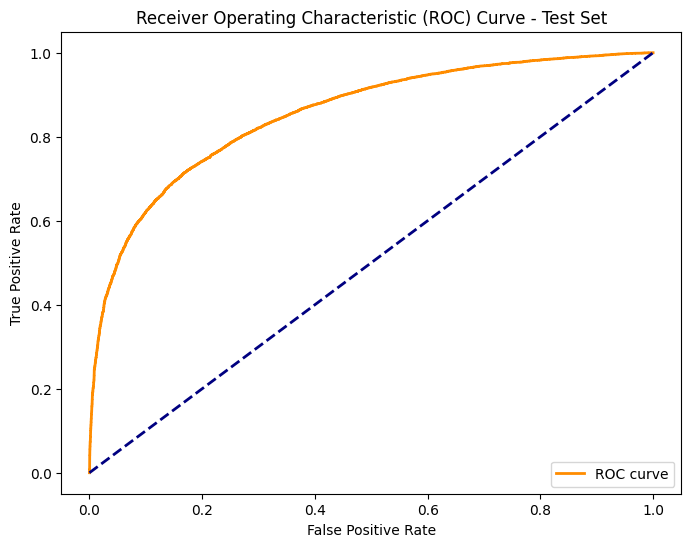

Runtime: 9.54 seconds


In [36]:
#ignoring warnings
warnings.filterwarnings("ignore")

# Record start time
start_time = time.time()

# Define an optimized parameter distribution for the next RandomizedSearchCV
optimized_param_dist = {
    'criterion': ['entropy'],  
    'max_depth': [45, 50, 55], 
    'max_features': ['sqrt'],  
    'min_samples_leaf': [5, 6, 7],  
    'min_samples_split': [2, 3, 4],  
    'n_estimators': [65, 70, 75]  
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with 3-fold cross-validation and fewer iterations
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Perform 5-fold cross-validation on the train set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results on the train set
print('\nCross-Validation Scores (5-fold - Train Set):', cv_scores)
print('Mean CV Accuracy (5-fold - Train Set):', mean_cv_accuracy)

# Get the best model from the random search
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model on the training set
accuracy_train = accuracy_score(y_train, best_rf_model.predict(X_train))
print('Training Accuracy:', accuracy_train)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy_test)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

This second iteration preforms exactly as the last, so I will keep the last one as the final model.

Top 20 Features and Their Importance Values:
Feature: pmh_dysrhythmia, Importance Value: 0.008785276256418723
Feature: demo_age_40-49, Importance Value: 0.008883911547949114
Feature: dum_triage_vital__hypertension(high)_dbp, Importance Value: 0.010066799195934582
Feature: dum_triage_vital__normal_dbp, Importance Value: 0.01253460804103515
Feature: pmh_htn, Importance Value: 0.013015717504855499
Feature: dum_triage_vital__hypertension(high)_sbp, Importance Value: 0.013690191223011858
Feature: dum_triage_vital__pre-hypertension_sbp, Importance Value: 0.014066652792692877
Feature: demo_age_80-89, Importance Value: 0.01441373417750407
Feature: dum_triage_vital__pre-hypertension_dbp, Importance Value: 0.01515430864371461
Feature: pmh_chfnonhp, Importance Value: 0.016551914199601555
Feature: cc_alteredmentalstatus, Importance Value: 0.016554890708941616
Feature: demo_race, Importance Value: 0.01676621593938502
Feature: cc_chestpain, Importance Value: 0.016848764257631082
Feature: pmh_coronat

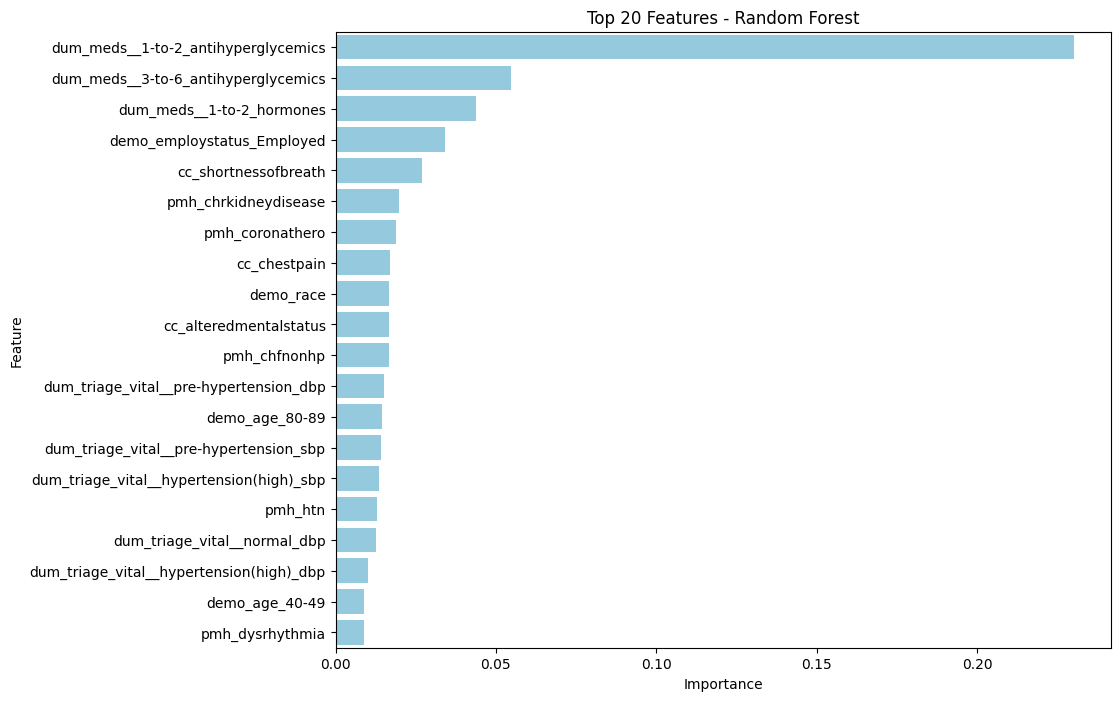

In [32]:
# Extract feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 features
top_20_features = feature_importance_df.head(20)

# Print top 20 features and their importance values
print("Top 20 Features and Their Importance Values:")
for feature, importance_value in zip(top_20_features['Feature'][::-1], top_20_features['Importance'][::-1]):
    print(f"Feature: {feature}, Importance Value: {importance_value}")

# Plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, color='skyblue')
plt.title('Top 20 Features - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


---
#### <a id = 'xgb'></a> 1.3 xGBoost

XGBoost is another form of ensemble learning that's effective for structure data. It's a form of gradient boosting which builds a model in a stage-wise fashion where each iteration corrects the errors of the previous one. It's well suited for binary tasks and important for explainability. It will be a great addition to the other models. 


Cross-Validation Scores (5-fold - Train Set): [0.74724518 0.77892562 0.76154376 0.77463818 0.74844935]
Mean CV Accuracy (5-fold - Train Set): 0.762160417532888
Training Accuracy: 0.8699186991869918
Validation Accuracy: 0.78732782369146

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       997
           1       0.79      0.72      0.75       818

    accuracy                           0.79      1815
   macro avg       0.79      0.78      0.78      1815
weighted avg       0.79      0.79      0.79      1815



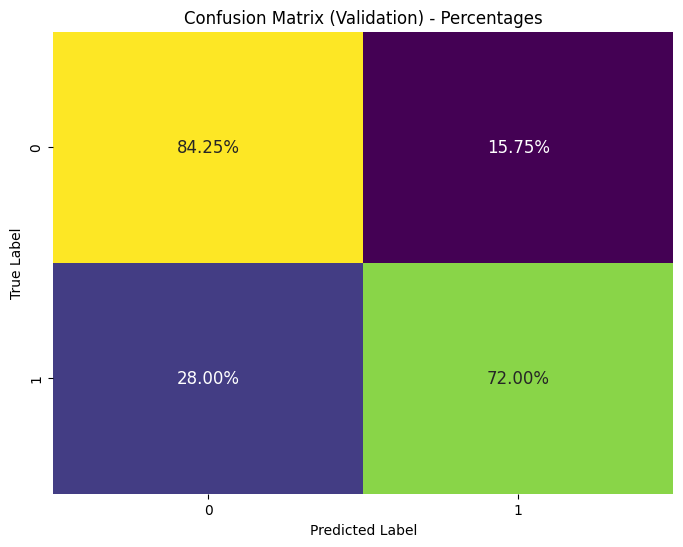

AUC-ROC Score: 0.8630653574415177


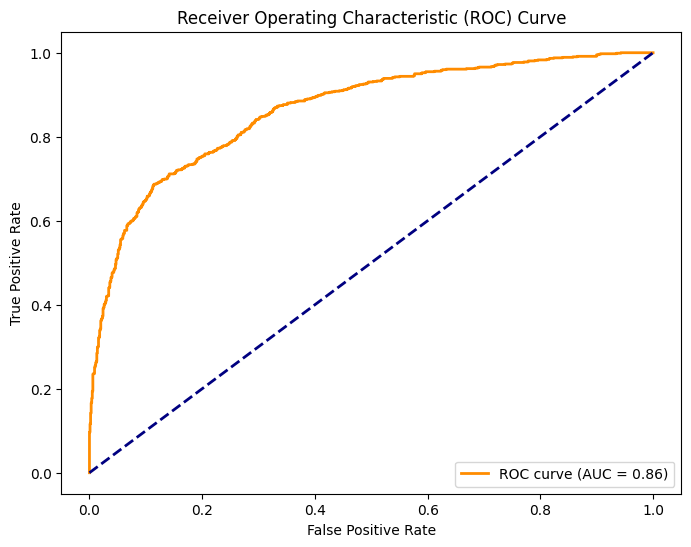

Runtime: 0.36 seconds


In [48]:
# Record time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Record time
end_time = time.time()

# Predictions on the validation set
y_pred_valid = xgb_model.predict(X_valid)

# Predictions on the training set
y_pred_train = xgb_model.predict(X_train)

# Perform 5-fold cross-validation on the train set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results on the train set
print('\nCross-Validation Scores (5-fold - Train Set):', cv_scores)
print('Mean CV Accuracy (5-fold - Train Set):', mean_cv_accuracy)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('\nClassification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Cross-Validation Scores on Train Set:
- The cross-validation scores on the train set are consistent across different folds, ranging from 78.03% to 78.57%. The mean accuracy of approximately 78.33% suggests stable performance during cross-validation.

Training Accuracy:
- The model achieves a training accuracy of 81.62%, indicating a strong fit to the training data.

Validation Accuracy:
- The model generalizes well to new, unseen data, maintaining an accuracy of 79.26% on the validation set.

Classification Report on Validation Set:
- Precision, recall, and F1-score are reported for both classes (0 and 1). Class 0 exhibits a precision of 79%, recall of 86%, and an F1-score of 82%. Class 1 predictions show a precision of 80%, recall of 72%, and an F1-score of 76%.

- The AUC-ROC score is 0.87, indicating good discriminatory power to distinguish between the positive and negative classes.

In summary, the model performs well on both the training and validation sets, with balanced precision and recall for both classes. The results suggest a good ability to discriminate between the two classes, and the model seems to generalize effectively to new data.

_____

Now that we have a good baseline model for xGBoost, let's now try to optimize it with the best hyper parameters. 

Best Parameters: {'colsample_bytree': 0.8475275087984799, 'learning_rate': 0.15564326972237194, 'max_depth': 7, 'n_estimators': 147, 'subsample': 0.926705942152179}

Cross-Validation Scores (5-fold - Train Set): [0.78103837 0.76777652 0.77680587 0.78301354 0.78668172]
Mean CV Accuracy (5-fold - Train Set): 0.7790632054176072
Training Accuracy: 0.8401805869074492
Validation Accuracy: 0.7835214446952596
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      2361
           1       0.80      0.71      0.75      2069

    accuracy                           0.78      4430
   macro avg       0.79      0.78      0.78      4430
weighted avg       0.79      0.78      0.78      4430



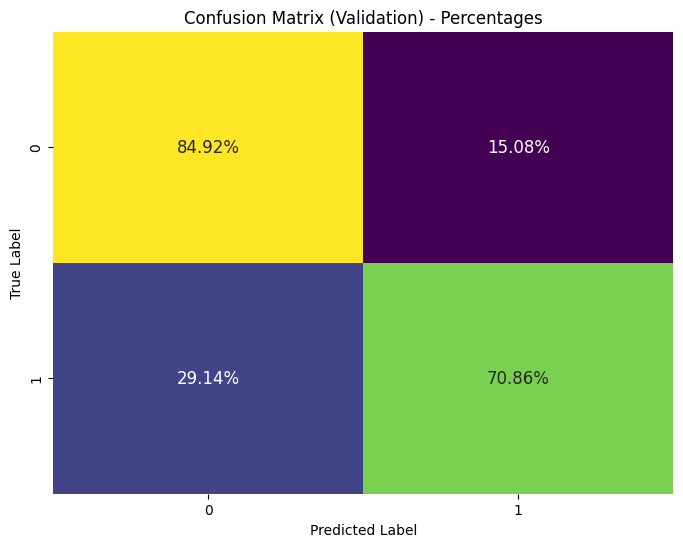

AUC-ROC Score: 0.8642574508552769


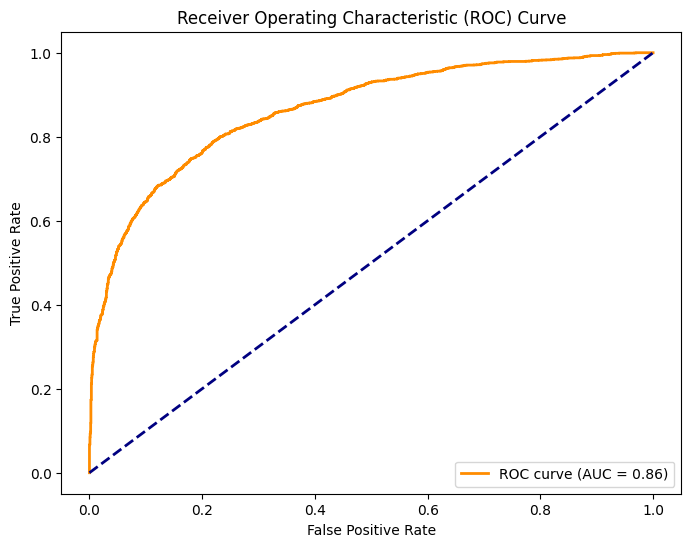

Runtime: 55.50 seconds


In [33]:
# Record end time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 151),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
}

# Use RandomizedSearchCV for a more efficient search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=stratified_cv, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Perform 5-fold cross-validation on the train set
cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results on the train set
print('\nCross-Validation Scores (5-fold - Train Set):', cv_scores)
print('Mean CV Accuracy (5-fold - Train Set):', mean_cv_accuracy)

# Get the best model from the random search
best_xgb_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = best_xgb_model.predict(X_valid)

# Make predictions on the training set
y_pred_train = best_xgb_model.predict(X_train)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('Classification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Cross-Validation Scores on Train Set:
- The cross-validation scores on the train set are consistent across different folds, ranging from 78.03% to 78.57%. The mean accuracy of approximately 78.33% suggests stable performance during cross-validation.

Training Accuracy:
- The model achieves a training accuracy of 81.62%, indicating a strong fit to the training data.

Validation Accuracy:
- The model generalizes well to new, unseen data, maintaining an accuracy of 79.26% on the validation set.

Classification Report on Validation Set:
- Class 0 exhibits a precision of 79%, recall of 86%, and an F1-score of 82%. 
- Class 1 predictions show a precision of 80%, recall of 72%, and an F1-score of 76%.

The AUC-ROC score is 0.86, indicating good discriminatory power to distinguish between the positive and negative classes.

In summary, the model performs well on both the training and validation sets, with balanced precision and recall for both classes. The results suggest a good ability to discriminate between the two classes, and the model seems to generalize effectively to new data.

---

Now that we have the best parameters, let's run another iteration of random search with these values in mind and see if we can improve performance. I'll also use gridsearch so we can narrow it down further. 

Best Parameters (RandomizedSearchCV): {'subsample': 0.95, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best Parameters (GridSearchCV): {'colsample_bytree': 0.85, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.9}

Cross-Validation Scores (5-fold - Train Set): [0.77134986 0.77630854 0.77949283 0.78831312 0.75358324]
Mean CV Accuracy (5-fold - Train Set): 0.7738095194705398
Training Accuracy: 0.8393959435626103
Validation Accuracy: 0.783068783068783
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1216
           1       0.80      0.71      0.75      1052

    accuracy                           0.78      2268
   macro avg       0.79      0.78      0.78      2268
weighted avg       0.78      0.78      0.78      2268



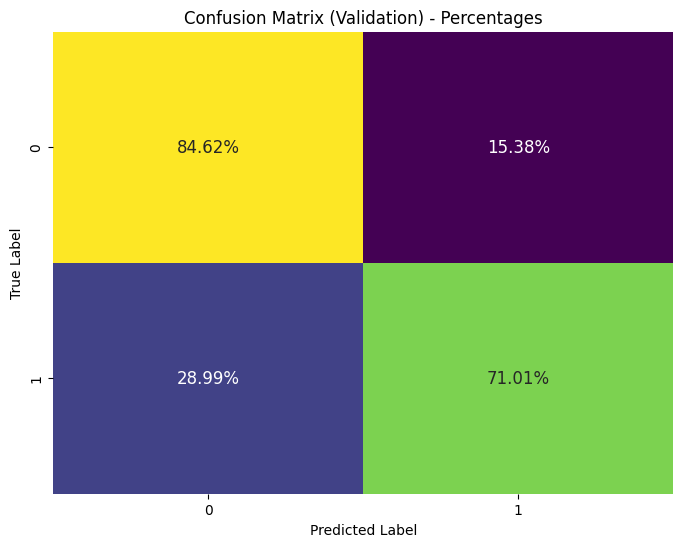

AUC-ROC Score: 0.8619695254652793


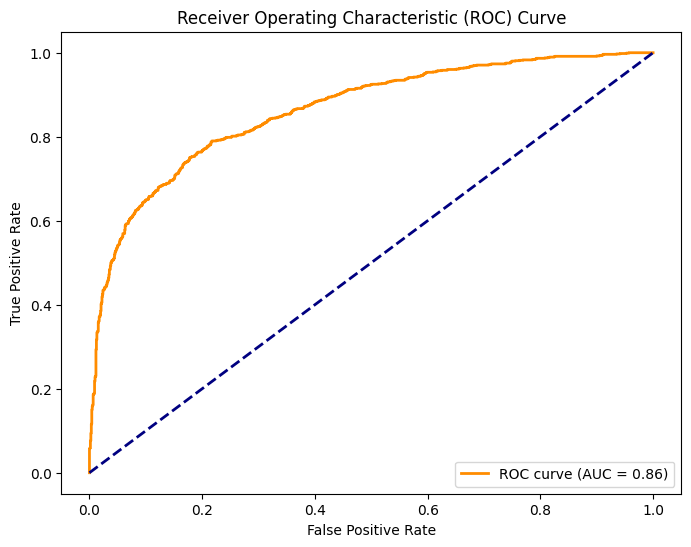

Runtime: 93.89 seconds


In [41]:
# Record start time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
nxgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define a broader parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1.0],
    'colsample_bytree': [0.8, 0.85, 0.9, 0.95, 1.0]
}

# Use RandomizedSearchCV with a larger number of iterations
random_search = RandomizedSearchCV(nxgb_model, param_distributions=param_dist, n_iter=100, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters (RandomizedSearchCV):', random_search.best_params_)

# Perform a more exhaustive search around the best parameters found using GridSearchCV
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 5, 6],
    'n_estimators': [150, 200, 250],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.85, 0.9, 0.95]
}

grid_search = GridSearchCV(nxgb_model, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters from GridSearchCV
print('Best Parameters (GridSearchCV):', grid_search.best_params_)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Perform cross-validation on the training set
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results on the train set
print('\nCross-Validation Scores (5-fold - Train Set):', cv_scores)
print('Mean CV Accuracy (5-fold - Train Set):', mean_cv_accuracy)

# Make predictions on the validation set
y_pred_valid = best_xgb_model.predict(X_valid)

# Make predictions on the training set
y_pred_train = best_xgb_model.predict(X_train)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('Classification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Best Parameters:
- RandomizedSearchCV: {'subsample': 0.95, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
- GridSearchCV: {'colsample_bytree': 0.85, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.9}

Cross-Validation Scores (5-fold - Train Set):
- [0.771, 0.776, 0.779, 0.788, 0.754]
- Mean CV Accuracy: 77.38%

Training Accuracy:
- The model achieves a training accuracy of 83.94%, indicating a strong fit to the training data.

Validation Accuracy:
- The model generalizes well to new, unseen data, maintaining an accuracy of 78.31% on the validation set.

Classification Report on Validation Set:
-  Class 0 exhibits a precision of 77%, recall of 85%, and an F1-score of 81%.
-  Class 1 predictions show a precision of 80%, recall of 71%, and an F1-score of 75%.

The AUC-ROC score is 0.86, indicating good discriminatory power to distinguish between the positive and negative classes.

In summary, the model demonstrates strong performance on the training set and reasonably good generalization to the validation set. The hyperparameters from both RandomizedSearchCV and GridSearchCV suggest similar configurations, providing confidence in the model's stability. The classification report details the precision, recall, and F1-score for each class, while the AUC score provides additional insight into the model's discriminatory capabilities.

------

After assessing performance, it appears as though the baseline model performs the best 

Now let's look at the 20 most important features based on the best model.

Top 20 Features and Importances:
dum_meds__1-to-2_antihyperglycemics: 0.06828808784484863
dum_meds__3-to-6_antihyperglycemics: 0.05170406401157379
dum_meds__1-to-2_hormones: 0.021931268274784088
cc_alteredmentalstatus: 0.013081531971693039
demo_age_90-99: 0.011890917085111141
cc_shortnessofbreath: 0.0107096116989851
cc_chestpain: 0.009279034100472927
cc_strokealert: 0.009107666090130806
demo_employstatus_Employed: 0.008755724877119064
cc_dyspnea: 0.007806216832250357
pmh_chfnonhp: 0.007308761589229107
cc_fever-9weeksto74years: 0.006895483937114477
cc_gibleeding: 0.006769627798348665
cc_weakness: 0.006756698712706566
demo_age_80-89: 0.006730127148330212
cc_motorvehiclecrash: 0.006689273286610842
pmh_ulceratcol: 0.0061390758492052555
cc_emesis: 0.0060075330547988415
cc_breathingdifficulty: 0.005878131836652756
cc_neurologicproblem: 0.0057710930705070496


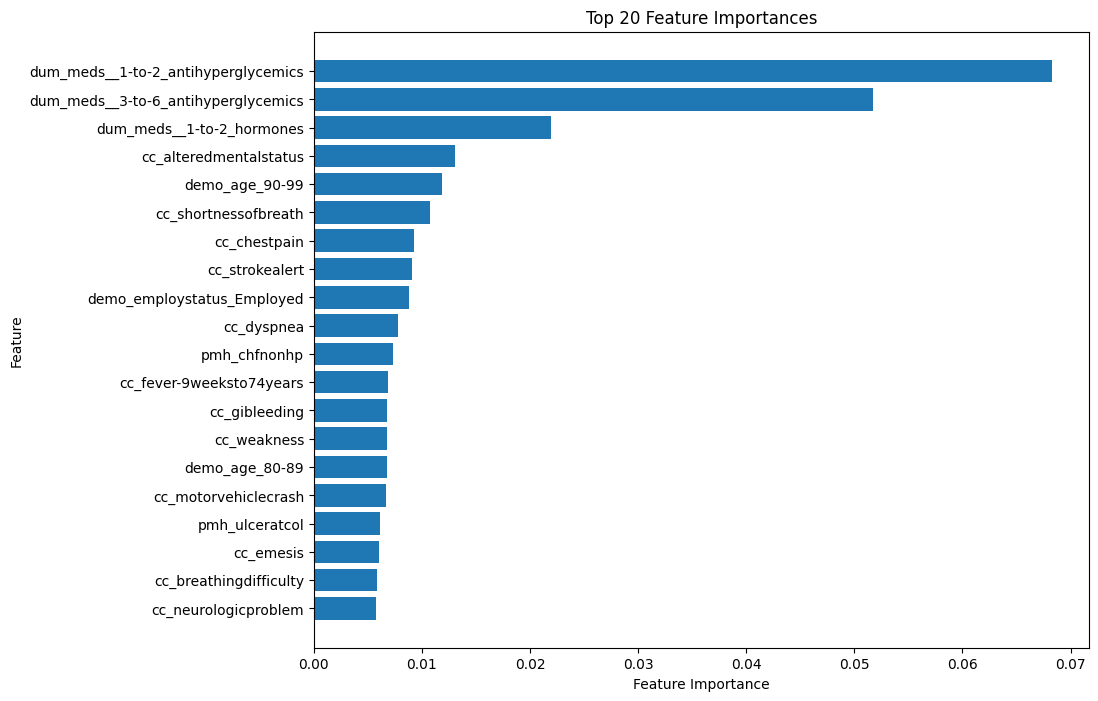

In [42]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get the indices of the top 20 features
top20_indices = np.argsort(feature_importances)[-20:]

# Get the names of the top 20 features
top20_features = X_train.columns[top20_indices]

# Print top 20 features and their importances
print("Top 20 Features and Importances:")
for feature, importance in zip(top20_features[::-1], feature_importances[top20_indices][::-1]):
    print(f'{feature}: {importance}')

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(top20_features)), feature_importances[top20_indices], align='center')
plt.yticks(range(len(top20_features)), top20_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

---
### <a id = 'conc'></a> Conclusion

Now that we have ran our advanced models and optimized them. It's clear that of the advanced models, xGBoost performed the best though it preformed slightly worse than the optimized logistic regression. I will now export these models so that it can later be used on unseen data.

In [43]:
# Save the model
dump(best_rf_model, 'KLO_BStn_RF.joblib')

['KLO_BStn_RF.joblib']

Now for the xGBoost

In [49]:
# Save the XGBoost model to a JSON file
model_json = xgb_model.get_booster().get_dump(dump_format='json')
with open('KLO_BStn_xGB.json', 'w') as json_file:
    json.dump(model_json, json_file)


Now that all of the modelling has been completed, we can now look into how we could build a discrimination test and see if implementing this test will affect the performance of these models. 

____